In [2]:
library(dplyr)
library(ggplot2)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [3]:
get_p <- function(ts) 2*pnorm(abs(ts), lower.tail=F)

alternative_power <- function(ct, mode='simulation', study = 'PBMC_4_combined', i_permu=1,
                             batch_suffix=''){
    output_dir <- sprintf('%s/output/%s/%s/%s', output_dir, mode, study, ct)
    par_df <- sprintf('%s_RNA_%i_pairs_%s_sampled_realistic_simulation_pars%s.txt', output_dir, n_pairs, sampling, batch_suffix[1]) %>% read.table
    fdr_list <- power_list <- list()
    for(i_permu in 1){
        res_mat <- readRDS(sprintf('%s_proposed_%s_sampled_results.rds', output_dir, sampling))[[i_permu]]
        pval_df <- data.frame(proposed = get_p(res_mat[,2]))
        res_mat <- sprintf('%s_Signac_%s_sampled_i_permu_%i_results.rds', output_dir, sampling, i_permu) %>% readRDS#%>% head
        pval_df$Signac <- get_p(res_mat[,2])
        res_mat <- sprintf('%s_SCENT_%s_sampled_i_permu_%i_results%s.rds', output_dir, sampling, i_permu,
                          ifelse(length(batch_suffix)>1, batch_suffix['SCENT'], '')) %>% readRDS
        pval_df$SCENT <- res_mat$boot_basic_p

        fdr <- numeric()
        power <- numeric()

        p_cutoffs <- seq(0.0001, 1, 0.0001)
        #, 'SEACells'
        for(method in c('proposed', 'Signac', 'SCENT')){
            fdrs <- sapply(1:length(p_cutoffs), function(i){
            sum(par_df$rho == 0 & pval_df[[method]] < p_cutoffs[i])/sum(pval_df[[method]] < p_cutoffs[i])
            })
            powers <- sapply(1:length(p_cutoffs), function(i){
            sum(par_df$rho != 0 & pval_df[[method]] < p_cutoffs[i])/sum(par_df$rho != 0)
            })
            fdrs[is.infinite(fdrs) | is.nan(fdrs)] <- NA
            powers[is.infinite(powers) | is.nan(powers)] <- NA
            fdr <- c(fdr, fdrs)
            power <- c(power, powers)
        }
        fdr_list[[i_permu]] <- fdr
        power_list[[i_permu]] <- power
        }
    prroc_df <- data.frame(FDR = fdr, power = power, method = rep(c('proposed', 'Signac', 'SCENT'), each = length(p_cutoffs)))
    g <- ggplot(prroc_df, aes(x = FDR, y = power, color = method)) +
    geom_point() +
    geom_line() +
                theme_classic(base_size=18)
    return(list(g, prroc_df))
}

# PBMC data

In [5]:
output_dir <- '../../analysis/simulation'

Warning message:
“Removed 40 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 40 rows containing missing values (`geom_line()`).”


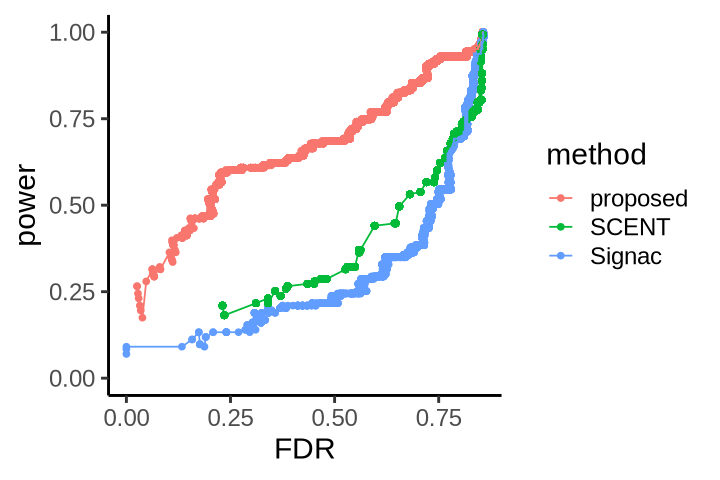

In [8]:
options(repr.plot.width = 6, repr.plot.height = 4)
n_pairs <- 1000
sampling <- 'random'

tmp <- alternative_power('CD14 Mono', study = 'PBMC_10k_nextgem')

tmp[[1]]

saveRDS(tmp[[2]], '../manuscript/results/PRROC.rds')

# Brain data

In [9]:
batch_suffix_vec <- c('_batch_adjusted', '_batch_as_covar_adjusted')
names(batch_suffix_vec) <- c('proposed', 'SCENT')

Warning message:
“Removed 40 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 40 rows containing missing values (`geom_line()`).”


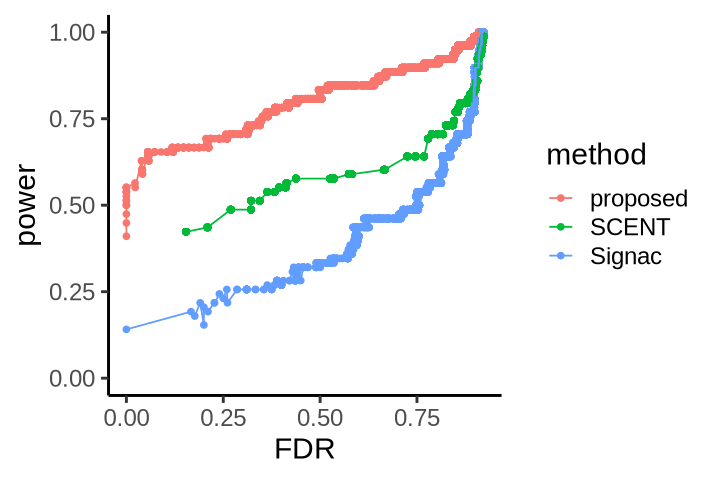

In [10]:
options(repr.plot.width = 6, repr.plot.height = 4)
n_pairs <- 1000
tmp <- alternative_power('Oligodendrocytes', mode='simulation_batch_effect', study = 'brain_CG',
                        batch_suffix = batch_suffix_vec)
tmp[[1]]
saveRDS(list(brain_CG=tmp[[2]]), '../manuscript/results/PRROC_batch_effect_SCENT_adjusted.rds')